### Assumptions Prior to Using This Module 

1. To use "balanced" data set, please run Analyzer to generate the dataset first (it may take about 30 mins)
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c-balanced.csv
   
2. To use regular data (the sampled dataset from Andromeda), there's nothing you need to do.
   - Example input: <project_dir>/loinc_predictor/data/andromeda-pond-hepatitis-c.csv
   

In [1]:
import pandas as pd 
from pandas import DataFrame, Series
import os, sys, re
import numpy as np
from decimal import Decimal
from utils_sys import highlight

import warnings
warnings.filterwarnings('ignore')  # action='once'

# local modules
from analyzer import load_data, save_data, load_performance
import loinc as lc

%matplotlib inline

### Determine Target Cohort

In [2]:
cohort = 'hepatitis-c'

### Define Feature Set

In [3]:
"""
Memo
----
1. medivo_test_result_type is a function of the following attributes: 
      "meta_sender_name",
      "receiving_organization_id",
      "test_order_code",
      "test_order_name",
      "test_result_code",
      "test_result_name",
      "test_result_loinc_code",
      "test_result_units_of_measure"
      
"""
from analyzer import sample_col_values
from loinc import FeatureSet

cat_cols = FeatureSet.cat_cols  # 22 vars
cont_cols = FeatureSet.cont_cols  # e.g. age
derived_cols = FeatureSet.derived_cols
# ... ['count']  # other possible vars: test result n-th percentile, normalized test frequency

target_cols = FeatureSet.target_cols  # ['test_result_loinc_code', ]

# cardinality < 100
low_card_cols = FeatureSet.low_card_cols # ['patient_gender', 'fasting', 'meta_sender_name' ]
high_card_cols = FeatureSet.high_card_cols

target_columns = cat_cols + cont_cols + target_cols

### Load (Curated) Training Data

note: Training data was saved prior to the variable encoding

In [4]:
from analyzer import load_src_data, analyze_values

# input_file = f"andromeda-pond-{cohort}.csv" # or f"andromeda-pond-{cohort}-balanced.csv"
# ts = load_data(input_file=input_file, warn_bad_lines=False)
ts = load_src_data(cohort=cohort, warn_bad_lines=False, canonicalized=True, processed=True)

print("(load) dim(df): {} | columns:\n{}\n".format(ts.shape, 
        list(ts.columns.values[:10])+['...']+list(ts.columns.values[-10:]))) 
# ... 'ts' at this point contains all variables

# check feature values
analyze_values(ts, cols=cat_cols, topn=10)  # topn: most common n feature values (and their counts)

[load] Loading default input data: andromeda-pond-hepatitis-c-processed.csv
(canonicalize) Operations: fill n/a + dehyphenate + replace_values + trim_tail + fill others (non-target classes)
(load) dim(df): (71224, 127) | columns:
['meta_package_key', 'input_filename', 'patient_date_of_birth', 'patient_gender', 'patient_state', 'patient_bill_type', 'diagnosis_codes', 'diagnosis_descriptions', 'laboratory_diagnosis', 'billing_diagnosis_codes', '...', 'meta_dict_orig', 'meta_dict_final', 'meta_ingestion_datetime', 'meta_original_filename', 'meta_sender_name', 'meta_sender_source', 'meta_sender_type', 'meta_sender_dataset', 'meta_sender_ver', 'medivo_test_result_type']

[1] name: patient_gender => values: 
[('M', 42620), ('F', 28555), (nan, 49)]
 ... mode: M
[2] name: patient_state => values: 
[('CA', 9616), ('TX', 8828), ('FL', 7549), ('NY', 5827), ('PA', 4453), ('NJ', 3864), ('MD', 3269), ('GA', 1902), ('NC', 1675), ('TN', 1556)]
 ... mode: CA
[3] name: patient_bill_type => values: 
[('P

{'patient_gender': [('M', 42620), ('F', 28555), (nan, 49)],
 'patient_state': [('CA', 9616),
  ('TX', 8828),
  ('FL', 7549),
  ('NY', 5827),
  ('PA', 4453),
  ('NJ', 3864),
  ('MD', 3269),
  ('GA', 1902),
  ('NC', 1675),
  ('TN', 1556)],
 'patient_bill_type': [('PI', 18695),
  ('PRIVATE INSURANCE', 14270),
  ('CM', 10032),
  (nan, 8672),
  ('MC', 5098),
  ('MEDICARE', 4390),
  ('MEDICAID', 2668),
  ('MD', 2549),
  ('MANAGE CARE FFS', 2436),
  ('CLIENT', 1161)],
 'fasting': [(nan, 61446),
  ('NOT FASTING', 3942),
  ('Y', 1986),
  ('N', 1334),
  ('U', 1269),
  ('FASTING', 1247)],
 'performing_organization_id': [(nan, 29269),
  ('BN', 13666),
  ('RN', 5484),
  ('CPLSW', 4374),
  ('SO', 2292),
  ('CB', 2118),
  ('TA', 1973),
  ('MB', 1743),
  ('DA', 1267),
  ('PDLCA', 1227)],
 'receiving_organization_id': [(nan, 37380),
  ('CPLSW', 4374),
  ('22', 3660),
  ('28', 3054),
  ('17', 3024),
  ('1', 2727),
  ('15', 2360),
  ('35', 1579),
  ('30', 1529),
  ('41', 1370)],
 'test_result_status': [(

### Feature Transformation
note: patient_date_of_birth => age

In [5]:
from transformer import to_age
from analyzer import col_values
from loinc import FeatureSet

tTransformed = False

FeatureSet.to_age(ts)
values = col_values(ts, col='age', n=10)
print("> age: {}".format(values))

# datatime columns

> age: [71 61 69 72 59 71 69 68 62 69]


### Subset Variables, Encode Variables and Handling Missing Values

In [6]:
from analyzer import feature_transform

regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)
highlight("Found {} reg vars | {} label vars".format(len(regular_vars), len(target_vars)))
msg = ""
msg += "... regular_vars:  {}\n".format(regular_vars)
msg += "... target vars:   {}\n".format(target_vars)
msg += "... derived vars:  {}\n".format(derived_vars)
msg += "... meta_vars:     {}\n".format(meta_vars)
print(msg)

ts = feature_transform(ts, drop_high_missing=False, pth_null=0.9, verbose=1)

Found 23 reg vars | 1 label vars
... regular_vars:  ['patient_gender', 'patient_state', 'patient_bill_type', 'fasting', 'performing_organization_id', 'receiving_organization_id', 'test_result_status', 'test_order_code', 'test_order_name', 'test_result_code', 'test_result_name', 'test_result_value', 'test_result_range', 'test_result_abnormal_flag', 'test_result_reference_range', 'test_result_units_of_measure', 'test_result_comments', 'test_cpt_code', 'panel_order_code', 'panel_order_name', 'meta_sender_name', 'medivo_test_result_type', 'age']
... target vars:   ['test_result_loinc_code']
... derived vars:  []
... meta_vars:     []

[transform] age: [71 61 69 72 59 71 69 68 62 69]
(encoder_vars2) low card vars (n=['patient_gender', 'fasting', 'meta_sender_name']):
3
 ... high card vars (n=['patient_bill_type', 'panel_order_name', 'test_order_code', 'performing_organization_id', 'test_result_range', 'medivo_test_result_type', 'test_result_abnormal_flag', 'panel_order_code', 'test_result_n

### Partition Variables

In [7]:
from analyzer import encode_labels, summarize_dict, get_sample_sizes
import collections, operator

codebook={'pos': 1, 'neg': 0, '+': 1, '-': 0}

tsX, tsY, ts_derived, ts_meta = FeatureSet.partition(ts)

print("> Found n(X)={}, n(Y)={}, n(Derived)={}, n(Meta):{}".format(
    tsX.shape[1], tsY.shape[1], ts_derived.shape[1], ts_meta.shape[1]))

# verify
assert tsX.shape[0] == tsY.shape[0]

[partition] 203 reg vars | 1 label vars
... regular_vars (X): ['patient_gender_1', 'patient_gender_2', 'patient_gender_3', 'patient_state_0', 'patient_state_1', 'patient_state_2', 'patient_state_3', 'patient_state_4', 'patient_state_5', 'patient_state_6', 'patient_bill_type_0', 'patient_bill_type_1', 'patient_bill_type_2', 'patient_bill_type_3', 'patient_bill_type_4', 'fasting_1', 'fasting_2', 'fasting_3', 'fasting_4', 'fasting_5', 'fasting_6', 'performing_organization_id_0', 'performing_organization_id_1', 'performing_organization_id_2', 'performing_organization_id_3', 'performing_organization_id_4', 'performing_organization_id_5', 'performing_organization_id_6', 'performing_organization_id_7', 'performing_organization_id_8', 'receiving_organization_id_0', 'receiving_organization_id_1', 'receiving_organization_id_2', 'receiving_organization_id_3', 'receiving_organization_id_4', 'receiving_organization_id_5', 'receiving_organization_id_6', 'test_result_status_0', 'test_result_status_1'

### Model Training

In [8]:
import utils_tree, utils_sys, analyzer
import collections
from analyzer import balance_by_downsampling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from loinc import TSet, FeatureSet, LoincTSet
from common import apply_scaling

def get_sample_size(y, code_book={}):
    if not code_book: code_book = TSet.codebook
    counter = collections.Counter(y)
    return (counter[codebook['neg']], counter[codebook['pos']])

# model training parameters 
n_fold = 5
n_min = n_fold  # min number of examples to train a classifier
scaling_method = 'minmax'
tBalance = True   # balance the data set? If True, will attempt to limit the sample size of the majority class

# data transformation
col_target = LoincTSet.col_target  # 'test_result_loinc_name'
# regular_vars, target_vars, derived_vars, meta_vars = FeatureSet.categorize_features(ts)

# subsampling parameters 
majority_max = 10    # majority class is only allowed to have at most this multiple of samples than the minority class
sampling_method = 'multiple'

X, y = tsX.values, tsY.values.flatten()
loinc_set = raw_labels = np.unique(y)
print("> dim(X): {}, sample(y): {}".format(X.shape, np.random.choice(loinc_set,20) ))

# feature scaling
X = apply_scaling(X, scaler=scaling_method)

# attributes for performance data
header = ['code', 'mean', 'std', 'n_pos', 'total']
sdict = {h:[] for h in header}
for code in loinc_set: 
    y_bin = analyzer.encode_labels(y, pos_label=code)
    
    n_neg0, n_pos0 = get_sample_size(y_bin)
    
    if n_pos0 >= n_min: # if n(pos) is above a min threshold, then train a model
        
        # we could have done subsampling here but then the else case wouldn't get a corret
        if tBalance: 
            X_eff, y_eff = balance_by_downsampling(X, y_bin, method=sampling_method, majority_max=majority_max)
            assert isinstance(y_eff, np.ndarray) and isinstance(X_eff, np.ndarray)
        else: 
            X_eff, y_eff = X, y_bin
        
        n_neg, n_pos = get_sample_size(y_eff)
        
        # training + evaluation (default classifier: logistic regression)
        scores = analyzer.eval_performance(X_eff, y_eff, model=None, cv=n_fold, random_state=53, verbose=1)
        # metric: f1 score
        
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print("... average Fmax: {}, std: {}".format(mean_score, std_score))
    else: 
        print("> (positive) sample size too small, n={}".format(n_pos0))
        mean_score = -1 
        std_score = -1
        
        # hypothetical sample sizes if one were to train this classifier
        n_neg = min(n_pos0, n_neg0) * majority_max
        n_pos = n_pos0
        
    print(f"... Code: {code} | sample size | n0(-): {n_neg0}, n0(+): {n_pos0} ->(subsample)-> n(-): {n_neg}, n(+): {n_pos}")
        
    sdict['code'].append(code)
    sdict['mean'].append(mean_score)
    sdict['std'].append(std_score)
    sdict['n_pos'].append(n_pos)
    sdict['total'].append(n_pos+n_neg)

# --------------------------------------------------
# save performance dataframe
df_perf = DataFrame(sdict, columns=header)
df_perf = df_perf.sort_values(by=['mean', ]) # ascending=False
analyzer.save_performance(df_perf, output_dir='result', cohort=cohort, verbose=1)  # other opts: output_file
# ... default sep: '|' but NOT ',' 


> dim(X): (71224, 203), sample(y): ['451765' '21642' '182824' '203935' '80100' '56390' '18358' '192955'
 '17590' '7401' '142364' '169359' '452243' '304501' '265231' '424838'
 '772020' '51599' '205708' '752279']
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 005025 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 10058 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 103317 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 103341 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209, 1:

> Fmax: 1.0 p_th: 0.981670065564348 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9792745739387335 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9803622318351132 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9534354465100845 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 111567 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 112532 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71050, 1: 174})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.970613964505222 | F1: 0.9859154929577464, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.4393122036368462 | F1: 0.9705882352941176, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.30609814318514933 | F1: 0.985

> Fmax: 1.0 p_th: 0.9594375821947942 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 134577 | sample size | n0(-): 70601, n0(+): 623 ->(subsample)-> n(-): 6230, n(+): 623
(encode_labels) sample size: Counter({0: 70885, 1: 339})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.9927007299270074 p_th: 0.15226004648272135 | F1: 0.9850746268656716, AUC: 0.9999566198160681
> 1 of KFold 5
> Fmax: 0.9925925925925926 p_th: 0.26399769968788733 | F1: 0.9774436090225563, AUC: 0.9998264792642721
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9849408797125532 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9911871438060842 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9682322302872662 | F1: 1.0, AUC: 1.0
... average Fmax: 0.99705866450392, std: 0.0036025478649227833
... Code: 134585 | sample size | n0(-): 70885, n0(+): 339 ->(subsample)-> n(-): 3390, n(+): 339
(encode_labels) samp

(encode_labels) sample size: Counter({0: 71185, 1: 39})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.986474244137331 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9668416518578817 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9811524271962361 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9825699204880559 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9946123065173703 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 142513 | sample size | n0(-): 71185, n0(+): 39 ->(subsample)-> n(-): 390, n(+): 39
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 142729 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 142778 | sample size | n0(-): 71221, n0(+):

... Code: 154328 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 155465 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9552598048098146 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8101120982477454 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8299908002102868 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9487138312021768 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.6714500257428703 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 15586 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (posi

> 4 of KFold 5
> Fmax: 0.9989615784008308 p_th: 0.8511330570168564 | F1: 0.9989615784008308, AUC: 0.9999982711001423
... average Fmax: 0.9983393751183376, std: 0.001404218609934884
... Code: 17426 | sample size | n0(-): 68819, n0(+): 2405 ->(subsample)-> n(-): 24050, n(+): 2405
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 174334 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 70945, 1: 279})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9813387942089621 | F1: 0.9911504424778761, AUC: 1.0
> 1 of KFold 5
> Fmax: 0.9818181818181818 p_th: 0.9873031113264915 | F1: 0.9818181818181818, AUC: 0.9974398361495136
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9903176336443176 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9531405764646799 | F1: 1.0, AUC: 1.0
> 4 

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9839351235141599 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.98828191179437 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9862123819204844 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.981085621024406 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9797945800655296 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 181826 | sample size | n0(-): 71218, n0(+): 6 ->(subsample)-> n(-): 60, n(+): 6
(encode_labels) sample size: Counter({0: 71185, 1: 39})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.42696006874856846 | F1: 0.9333333333333333, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9872292115634526 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9835620962509033

> 3 of KFold 5
> Fmax: 1.0 p_th: 0.945836566541794 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9987325728770595 p_th: 0.8019362253660511 | F1: 0.9987325728770595, AUC: 0.999994205317201
... average Fmax: 0.999746514575412, std: 0.0005069708491761915
... Code: 19208 | sample size | n0(-): 69253, n0(+): 1971 ->(subsample)-> n(-): 19710, n(+): 1971
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9723356070609722 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9741563134819543 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.971812032134019 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9849591495686368 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9798993758574052 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 192526 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 

> Fmax: 0.9940119760479043 p_th: 0.5940443610569452 | F1: 0.9940119760479043, AUC: 0.999927245212735
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9581143851356364 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.993939393939394 p_th: 0.9798985877835905 | F1: 0.993939393939394, AUC: 0.999956347127641
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9718260471707778 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9975902739974597, std: 0.002951388813292176
... Code: 19687 | sample size | n0(-): 70810, n0(+): 414 ->(subsample)-> n(-): 4140, n(+): 414
(encode_labels) sample size: Counter({0: 71083, 1: 141})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9414453213055198 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9459817931453819 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8424869974782343 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9818181818181818 p_th: 0.9728319394133315 | F1: 0.9642857

... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9886597666971334 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8893891606719896 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9751311703658805 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9612267008984015 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.5378727970724698 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 204057 | sample size | n0(-): 71216, n0(+): 8 ->(subsample)-> n(-): 80, n(+): 8
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 204073 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.8186732423366565 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_

> (positive) sample size too small, n=1
... Code: 206060 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 206243 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9463103339163611 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.772468377824327 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.8 p_th: 0.4975721251229816 | F1: 0.5, AUC: 0.96875
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9897092965191671 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7456787259323923 | F1: 1.0, AUC: 1.0
... average Fmax: 0.96, std: 0.07999999999999999
... Code: 20644 | sample size | n0(-): 71216, n0(+): 8 ->(subsample)-> n(-): 80, n(+): 8
(e

(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 21626 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 21642 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 216960 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 218404 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 223123 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampli

... Code: 23457 | sample size | n0(-): 71055, n0(+): 169 ->(subsample)-> n(-): 1690, n(+): 169
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 236562 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71215, 1: 9})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7788631581584319 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.919861887373222 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9585119584558333 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.7960138736208207 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9537556894733608 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 237610 | sample size | n0(-): 71215, n0(+): 9 ->(subsample)-> n(-): 90, n(+): 9
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> 

(encode_labels) sample size: Counter({0: 71102, 1: 122})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9811809777034439 | F1: 0.9615384615384615, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.43615780777996305 | F1: 0.9795918367346939, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8548762947551772 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.6324533981519018 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9787234042553191 p_th: 0.9691535149928681 | F1: 0.9787234042553191, AUC: 0.9993169398907104
... average Fmax: 0.9957446808510639, std: 0.008510638297872353
... Code: 25015 | sample size | n0(-): 71102, n0(+): 122 ->(subsample)-> n(-): 1220, n(+): 122
(encode_labels) sample size: Counter({0: 71098, 1: 126})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.98

(encode_labels) sample size: Counter({0: 71145, 1: 79})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9930639455116888 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9814375487845288 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9705080674110433 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9931493339306302 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9857849446663127 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 264648 | sample size | n0(-): 71145, n0(+): 79 ->(subsample)-> n(-): 790, n(+): 79
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 264663 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merg

... Code: 269712 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71202, 1: 22})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9433963165432191 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9310095565848082 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9783519086849307 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9032452140943645 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9473554534653327 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 27318 | sample size | n0(-): 71202, n0(+): 22 ->(subsample)-> n(-): 220, n(+): 22
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9670320371904372 | F1: 1.

... Code: 28688 | sample size | n0(-): 71209, n0(+): 15 ->(subsample)-> n(-): 150, n(+): 15
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.36580626618296064 | F1: 0.8, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8794722233388286 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9541804558386929 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9706497187686427 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9578233897466302 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 28712 | sample size | n0(-): 71212, n0(+): 12 ->(subsample)-> n(-): 120, n(+): 12
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7979408577333783 | F1:

(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 299016 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71201, 1: 23})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.7096311557771544 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9358124133116501 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.8745112743280443 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9721122585058437 | F1: 0.888888888888889, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9702260450857143 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 29918 | sample size | n0(-): 71201, n0(+): 23 ->(subsample)-> n(-): 230, n(+): 23
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 30130 | sample size | n0(-): 

> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9517803827735541 | F1: 0.975609756097561, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9954425943369472 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9845997845336383 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9944849139187811 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 303842 | sample size | n0(-): 71126, n0(+): 98 ->(subsample)-> n(-): 980, n(+): 98
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 303859 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9857632987669006 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9911602057346884 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9899789370438872 | F1: 1.0,

> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9904571464495332 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 30916 | sample size | n0(-): 71139, n0(+): 85 ->(subsample)-> n(-): 850, n(+): 85
(encode_labels) sample size: Counter({0: 70308, 1: 916})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.997289972899729 p_th: 0.45164550753661736 | F1: 0.9945652173913043, AUC: 0.9999970334156066
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8644797906308781 | F1: 0.9972752043596731, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9538283524025866 | F1: 0.991869918699187, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.8185880233562819 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9238840070315766 | F1: 0.9972752043596731, AUC: 1.0
... average Fmax: 0.9994579945799458, std: 0.001084010840108407
... Code: 30940 | sample size | n0(-): 70308, n0(+): 916 ->(subsample)-> n(-): 9160, n(+): 916
(encode_labe

> Fmax: 0.9969040247678018 p_th: 0.9638413667897996 | F1: 0.9908256880733944, AUC: 0.9999924166590833
... average Fmax: 0.9963113402418193, std: 0.002293715833394451
... Code: 322867 | sample size | n0(-): 70410, n0(+): 814 ->(subsample)-> n(-): 8140, n(+): 814
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 323238 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 325852 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71212, 1: 12})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 0.8 p_th: 0.9904663490344975 | F1: 0.8, AUC: 0.9027777777777777
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9869530338604635 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0

(encode_labels) sample size: Counter({0: 70362, 1: 862})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9599942666224929 | F1: 0.9914040114613181, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.960057652326386 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9212359554701505 | F1: 0.9971014492753623, AUC: 1.0
> 3 of KFold 5
> Fmax: 0.9971014492753623 p_th: 0.5642176048767995 | F1: 0.9971014492753623, AUC: 0.9999966276371877
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7666574331974019 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9994202898550725, std: 0.0011594202898550954
... Code: 339143 | sample size | n0(-): 70362, n0(+): 862 ->(subsample)-> n(-): 8620, n(+): 862
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.3016

> Fmax: 1.0 p_th: 0.987408457320989 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9906166624821584 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9887783264778756 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9848734822770314 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9913726429115048 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 384834 | sample size | n0(-): 71215, n0(+): 9 ->(subsample)-> n(-): 90, n(+): 9
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 385187 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71221, 1: 3})
> (positive) sample size too small, n=3
... Code: 38794 | sample size | n0(-): 71221, n0(+): 3 ->(subsample)-> n(-): 30, n(+): 3
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 390179 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-

> Fmax: 1.0 p_th: 0.9856796683425796 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.5669198660156712 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9860256798421787 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9565166474311225 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 44859 | sample size | n0(-): 71213, n0(+): 11 ->(subsample)-> n(-): 110, n(+): 11
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 44917 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9433820909865587 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8305083861920769 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.800744123808834 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax:

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9929588774742663 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.8889666444054931 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.888888888888889 p_th: 0.11368089643082142 | F1: 0.8571428571428571, AUC: 0.9930555555555556
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9415667568095003 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9757813920898751 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9777777777777779, std: 0.04444444444444442
... Code: 473835 | sample size | n0(-): 71206, n0(+): 18 ->(subsample)-> n(-): 180, n(+): 18
(encode_labels) sample size: Counter({0: 70652, 1: 572})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.939044869178042 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.5594564440058165 | F1:

... Code: 493114 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 4
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 495036 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71211, 1: 13})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9859133704027786 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9845348700892118 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9871819570193243 | F1: 0.8571428571428571, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9499060399651529 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.95234702790407 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 495416 | sample size | n0(-): 71211, n0(+): 13 ->(subsample)-> n(-): 130, n(+): 13
(encode_labels) sample size: Counter({0: 711

(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 516492 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 51797 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 51813 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71222, 1: 2})
> (positive) sample size too small, n=2
... Code: 51896 | sample size | n0(-): 71222, n0(+): 2 ->(subsample)-> n(-): 20, n(+): 2
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 51912 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71209, 1: 15})
(balance_by_downsamplin

> Fmax: 1.0 p_th: 0.9816820558813009 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9882381614338677 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 542183 | sample size | n0(-): 71186, n0(+): 38 ->(subsample)-> n(-): 380, n(+): 38
(encode_labels) sample size: Counter({0: 71219, 1: 5})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9747078322276592 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9353483300569125 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9697285761675846 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9831685891876076 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7396594174494112 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 544346 | sample size | n0(-): 71219, n0(+): 5 ->(subsample)-> n(-): 50, n(+): 5
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size to

> Fmax: 1.0 p_th: 0.9308569535254962 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9300610582982602 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9043648859057059 | F1: 0.888888888888889, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.22984764157726204 | F1: 0.8571428571428571, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.995458406104111 | F1: 0.888888888888889, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 58024 | sample size | n0(-): 71202, n0(+): 22 ->(subsample)-> n(-): 220, n(+): 22
(encode_labels) sample size: Counter({0: 71203, 1: 21})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9900606728619907 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9519092718753915 | F1: 0.888888888888889, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9769276732530849 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9936640051018446 | F1: 1.0, AUC: 1.0
> 4

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.6059467720568218 | F1: 0.9743589743589743, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9904217790417458 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9560466691909341 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9844796925360131 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9824124052756998 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 611517 | sample size | n0(-): 71131, n0(+): 93 ->(subsample)-> n(-): 930, n(+): 93
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 61747 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 61895 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(enco

(encode_labels) sample size: Counter({0: 68104, 1: 3120})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9135601079275051 | F1: 0.9968051118210862, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.906252877186987 | F1: 0.9984, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.9991980753809142 p_th: 0.9471411524988972 | F1: 0.9983974358974359, AUC: 0.9999989727153189
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.5923159649610771 | F1: 0.9991993594875901, AUC: 1.0
> 4 of KFold 5
> Fmax: 0.9984 p_th: 0.4836571081940745 | F1: 0.9975980784627702, AUC: 0.9999984590729784
... average Fmax: 0.9995196150761828, std: 0.0006401928958590387
... Code: 67686 | sample size | n0(-): 68104, n0(+): 3120 ->(subsample)-> n(-): 31200, n(+): 3120
(encode_labels) sample size: Counter({0: 71220, 1: 4})
> (positive) sample size too small, n=4
... Code: 67702 | sample size | n0(-): 71220, n0(+): 4 ->(subsample)-> n(-): 40, n(+): 

(encode_labels) sample size: Counter({0: 69187, 1: 2037})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9800196707395515 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9367691927898133 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 0.998769987699877 p_th: 0.8870499001508164 | F1: 0.9963190184049079, AUC: 0.9999975876264536
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9833395618894704 | F1: 0.9987730061349693, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.6201232238026283 | F1: 1.0, AUC: 1.0
... average Fmax: 0.9997539975399754, std: 0.0004920049200491938
... Code: 7187 | sample size | n0(-): 69187, n0(+): 2037 ->(subsample)-> n(-): 20370, n(+): 2037
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 724864 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71219, 1

(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9409741062960068 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.2855217277042945 | F1: 0.9333333333333333, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.990359077059763 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.7398772965875428 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9941321168342196 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 7427 | sample size | n0(-): 71187, n0(+): 37 ->(subsample)-> n(-): 370, n(+): 37
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 744441 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71218, 1: 6})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KF

> Fmax: 1.0 p_th: 0.9684827494415696 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9762760523115539 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9773639107552816 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 771477 | sample size | n0(-): 71214, n0(+): 10 ->(subsample)-> n(-): 100, n(+): 10
(encode_labels) sample size: Counter({0: 70837, 1: 387})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9546439822358315 | F1: 0.9936305732484078, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9806683346982955 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9792009689231402 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9620660076090559 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9855822734397955 | F1: 0.9935483870967742, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 772020 | sample size | n0(-): 70837, n0(+): 387 ->(subsamp

> Fmax: 1.0 p_th: 0.9270133899474428 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9811211403127498 | F1: 0.8, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.7506658086927714 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 79053 | sample size | n0(-): 71213, n0(+): 11 ->(subsample)-> n(-): 110, n(+): 11
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 79095 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 79178 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 791863 | sample size | n0(-): 71223, n0(+): 1 ->(subsample)-> n(-): 10, n(+): 1
(encode_labels) sample size: Counter({0: 71223, 1: 1})
> (positive) sample size too small, n=1
... Code: 7989 | sample siz

> Fmax: 1.0 p_th: 0.9451658025255033 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9770823624827105 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.8134106316840506 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 823781 | sample size | n0(-): 71218, n0(+): 6 ->(subsample)-> n(-): 60, n(+): 6
(encode_labels) sample size: Counter({0: 71216, 1: 8})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.954149871396931 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9869615298822382 | F1: 1.0, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9794717106503237 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.9630241462134024 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9823940242401898 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 823799 | sample size | n0(-): 71216, n0(+): 8 ->(subsample)-> n(-): 80, n(+): 8
(encode_labels

> Fmax: 1.0 p_th: 0.943210016078282 | F1: 1.0, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9372097646160666 | F1: 0.9655172413793104, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 93179 | sample size | n0(-): 71150, n0(+): 74 ->(subsample)-> n(-): 740, n(+): 74
(encode_labels) sample size: Counter({0: 71202, 1: 22})
(balance_by_downsampling) dim(X): (71224, 203), nl: 2, labels: [0 1] | nf=203
... After merging (X, y) => dim(X): (71224, 204)
> 0 of KFold 5
> Fmax: 1.0 p_th: 0.9954665074079823 | F1: 1.0, AUC: 1.0
> 1 of KFold 5
> Fmax: 1.0 p_th: 0.9754437791354603 | F1: 0.9090909090909091, AUC: 1.0
> 2 of KFold 5
> Fmax: 1.0 p_th: 0.9937578613506347 | F1: 1.0, AUC: 1.0
> 3 of KFold 5
> Fmax: 1.0 p_th: 0.2509841383246796 | F1: 0.8571428571428571, AUC: 1.0
> 4 of KFold 5
> Fmax: 1.0 p_th: 0.9784899921493707 | F1: 1.0, AUC: 1.0
... average Fmax: 1.0, std: 0.0
... Code: 93187 | sample size | n0(-): 71202, n0(+): 22 ->(subsample)-> n(-): 220, n(+): 22
(encode_labels) sample size: Counter

### Visualize Results

> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
> dim(performance matrix): (733, 5)
(label_by_performance) cols(df_perf): ['code' 'mean' 'std' 'n_pos' 'total']
(label_by_performance) dim(df_perf): (733, 5)
1. Total number of codes: 733 | n(low_sample): 422(57.572%), n(scored):311(42.428%), n(high scored):310(42.292%)
2. Pecentage scored codes: 42.428%
3. Percentage "good" codes: 42.292%
[analysis] N(codes; cohort=hepatitis-c): 733
...        n(easy): 310 | ratio: 0.4229195088676671
...        n(hard): 1 | ratio: 0.001364256480218281
...        n(low):  422 | ratio: 0.5757162346521146
1. Total number of codes: 733 | n(low_sample): 422, n(scored):311, n(high scored):310
2. Fraction of scored codes: 0.4242837653478854
3. Fraction of highly scored codes: 0.4229195088676671
       code      mean       std  n_pos  total
0     28654  1.000000  0.000000     11    121
13    21576  1.000000  0.000000     19    209
23   427682  1.000000  0.000000     12    132
22    20289 

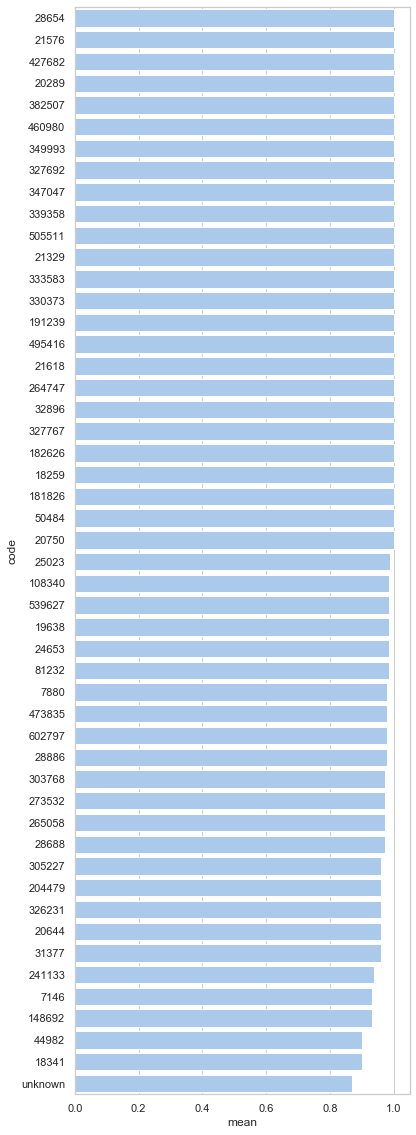

In [9]:
"""

Memo
---- 
1. performance plot

   perplot: https://pypi.org/project/perfplot/
"""
import seaborn as sns
import matplotlib.pyplot as plt
from analyzer import load_performance, label_by_performance
from utils_sys import size_hashtable

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 20))
sns.set_color_codes("pastel")

#---------------------------------------------

# load performance data
cohort = 'hepatitis-c'
df_perf = load_performance(input_dir='result', cohort=cohort)
print("> dim(performance matrix): {}".format(df_perf.shape))

# sort ~ performance scores 
# df_perf = df_perf.sort_values(by=['mean', ], ascending=False)

categories = ['easy', 'hard', 'low']
ccmap = label_by_performance(cohort=cohort, categories=categories)
N = size_hashtable(ccmap)
N_easy = len(ccmap['easy'])
N_hard = len(ccmap['hard'])
N_low = len(ccmap['low'])
print("[analysis] N(codes; cohort={}): {}".format(cohort, N))
print("...        n(easy): {} | ratio: {}".format(N_easy, N_easy/(N+0.0)))
print("...        n(hard): {} | ratio: {}".format(N_hard, N_hard/(N+0.0)))
print("...        n(low):  {} | ratio: {}".format(N_low,  N_low/(N+0.0)))

header = ['code', 'mean', 'std', 'n_pos']
codes = df_perf['code']
n_codes = len(codes)
scores = df_perf['mean']

# some statistics
score_high = 0.90
score_low = 0.50

codes_low_sz = ccmap['low']
codes_scored = np.hstack( [ccmap['easy'], ccmap['hard']] )
codes_high_score = ccmap['easy']
assert n_codes == len(codes_low_sz) + len(codes_scored)

print("1. Total number of codes: {} | n(low_sample): {}, n(scored):{}, n(high scored):{}".format(n_codes, 
   len(codes_low_sz), len(codes_scored), len(codes_high_score)))

r_scored = len(codes_scored)/(n_codes+0.0)
rh = len(codes_high_score)/(n_codes+0.0)
print("2. Fraction of scored codes: {}".format(r_scored))
print("3. Fraction of highly scored codes: {}".format(rh))

# Effective performance dataframe, ruling out those codes without scores (due to low sample sizes)
df_eff = df_perf.loc[df_perf['mean'] >= 0.0]

n_offset = 25
df_topn = df_eff.sort_values(['mean', ], ascending=False).head(n_offset)
df_botn = df_eff.sort_values(['mean', ], ascending=True).head(n_offset)
# print(df_botn)

# codes = [str(c) for c in df_botn['code'].values]
# print('lower codes: {}'.format(codes))
# scores = df_botn['mean'].values
# print('scores: {}'.format(scores))

# top n + bottom n
dfe = pd.concat([df_topn, df_botn], ignore_index=True)
dfe.sort_values(by=['mean', ], ascending=False, inplace=True)
codes = [str(c) for c in dfe['code'].values]
scores = dfe['mean'].values
# print('lower(n)+higher codes(n): {}'.format(codes))
# print('scores: {}'.format(scores))
print(dfe)

# sns.barplot(x="total", y="abbrev", data=crashes,
#             label="Total", color="b")

# --------------------
# ax = sns.barplot(x='mean', y='code', data=df_botn)
# print("-------------------------\n\n")
# print("> dtype: {}".format(df_botn.dtypes))
# print(df_botn.head(10))

# dfe = dfe[['mean', 'code']]
# dfe.plot(kind='bar')

sns.barplot(x='mean', y='code', data=dfe, order=dfe['code'], # order has to be specified; even if already sorted!!!
            label="LOINC", color="b", orient='h')

# ax = sns.barplot(x='mean', y='code', data=df)

# ax.set_xlabel('Fmax Score')
# ax.set_ylabel('LOINC')